# Heatmap
(main web page) http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

(ref github)https://github.com/jacobgil/pytorch-grad-cam/blob/master/grad-cam.py

## test image loading

In [84]:
import os 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import scipy
from torch.autograd import Variable
from torch.nn import functional as F
from PIL import Image
from torch import topk
from torchvision.transforms import Resize
import glob # read path data

In [85]:
# gpu setting
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# setting path
NAME_OF_CLASS = ["normal","lgd",'hgd','cancer'] # This name same with name of file
JSON_PATH = '/disk1/yjkim/json/intestine/c4json'
LOAD_ROOT_PATH = '/disk1/yjkim/jupyter/weight/intestine'
LOAD_CLASS = 'c4'
LOAD_PATH = os.path.join(LOAD_ROOT_PATH,'dens161',LOAD_CLASS,'83.82_13.pt')

# setting hyper parameter
BATCH_SIZE = 40
WORKERS = 2
IMG_SIZE = 224

In [86]:
# dataset
train_dataset = PathDataset(DATA_PATH=JSON_PATH,IMAGE_SIZE = IMG_SIZE, split='train')
val_dataset = PathDataset(DATA_PATH=JSON_PATH,IMAGE_SIZE = IMG_SIZE, split='val')
test_dataset = PathDataset(DATA_PATH=JSON_PATH,IMAGE_SIZE = IMG_SIZE, split='test')

# dataloader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                                           num_workers = WORKERS, pin_memory = True)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                                           num_workers = WORKERS, pin_memory = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                                           num_workers = WORKERS, pin_memory = True)


In [105]:
LABEL_test = []
PATH_test = []
for _, labels , pathes in test_loader:
    LABEL_test += labels.reshape(-1,len(labels)).tolist()[0]
    PATH_test +=pathes

In [109]:
LABEL_test = [int(i) for i in LABEL_test]

In [ ]:
PATH_test

## test model loading

In [142]:
#load model
load_model = torch.load(LOAD_PATH)

## Image

In [578]:
test_img_path = os.path.join(root_path,'hgd','01710668 HGD0001.jpg')

test_img = []
test_path = []

for imgs, _ , pathes in test_loader:
    for img, path in zip(imgs,pathes):
        if path == test_img_path:
            test_img.append(img)
            test_path.append(path)
            break

In [579]:
test_path

['/disk1/yjkim/data/endo/intestine/ver8/hgd/01710668 HGD0001.jpg']

In [580]:
test_img[0].shape

torch.Size([3, 224, 224])

In [581]:
tran_image = test_img[0]

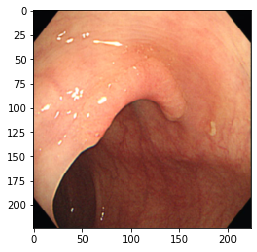

In [582]:
plt.imshow(tran_image.permute(1, 2, 0))

## Heatmap

In [583]:
# input selected data 
cuda_image = tran_image.to(device)
cuda_image = Variable(cuda_image)

prediction = load_model(cuda_image.unsqueeze(0))
label = prediction.max(1)[1]
print(NAME_OF_CLASS[label])

lgd


## Feature map

In [584]:
weight_softmax_params = list(load_model._modules.get('classifier').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax.shape

(4, 2208)

In [585]:
class Remodel(nn.Module):
    def __init__(self, original_model):
        super(Remodel, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0]))
        
    def forward(self, x):
        x = self.features(x)
        return x

In [586]:
# class ResNet50Bottom(nn.Module):
#     def __init__(self, original_model):
#         super(ResNet50Bottom, self).__init__()
#         self.features = nn.Sequential(*list(original_model.children())[:-2])
        
#     def forward(self, x):
#         x = self.features(x)
#         return x

In [587]:
dense161_conv2 = Remodel(load_model)

In [588]:
outputs = dense161_conv2(tran_image.unsqueeze(0).cuda())

In [589]:
outputs.shape

torch.Size([1, 2208, 7, 7])

## Overlap of heatmap with image

In [590]:
def getCAM(outputs ,weight_fc,  class_idx):
    _, nc, h, w = outputs.shape
    cam = weight_fc[class_idx].dot(outputs.reshape((nc, h*w)).data.cpu().numpy())
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

In [591]:
outputs.shape

torch.Size([1, 2208, 7, 7])

In [592]:
weight_softmax.shape

(4, 2208)

In [593]:
cam_img = getCAM(outputs,weight_softmax,label)


## Saving a heatmap , raw image , and  overlap image

In [594]:
from yjlib.ShowResult import ShowResult

In [595]:
showresult = ShowResult()

In [596]:
img_arr = [cam_img,tran_image.permute(1, 2, 0)]

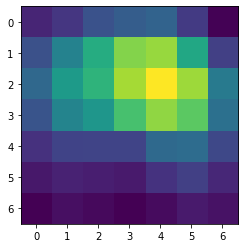

In [597]:
plt.imshow(cam_img)

Predict: lgd
hgd/01710668 HGD0001.jpg


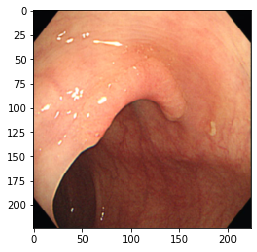

In [598]:
plt.imshow(tran_image.permute(1, 2, 0))
print('Predict:',NAME_OF_CLASS[label])
print(test_img_path[38:])

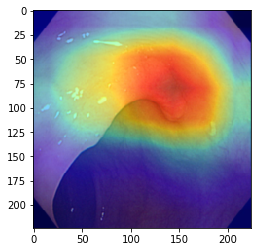

In [599]:
plt.imshow(tran_image.permute(1, 2, 0))
resize_cam_img = Resize(224)(Image.fromarray(cam_img))
plt.imshow(resize_cam_img, alpha=0.5, cmap='jet');


In [461]:
cam_img = getCAM(outputs,weight_softmax,1)

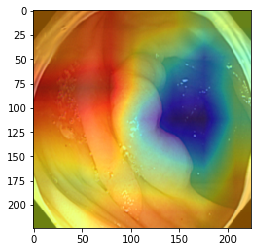

In [462]:
plt.imshow(tran_image.permute(1, 2, 0))
resize_cam_img = Resize(224)(Image.fromarray(cam_img))
plt.imshow(resize_cam_img, alpha=0.5, cmap='jet');


## Image Overlay

In [43]:
from yjlib.prep.ImgPrep import ImgPrep 
imgPrep = ImgPrep() 

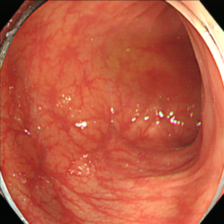

In [44]:
# read
back_img = Image.open(pathes[19])

# black remove
remove_back_img = Image.fromarray(imgPrep.remove_pad(np.array(back_img)))

# resizing
remove_back_img= Resize(224)(remove_back_img)
remove_back_img

In [ ]:
np.uint8()

In [75]:
(cam_img*255).shape

(7, 7)

In [76]:
cam_pil = Image.fromarray(cam_img*255)

In [77]:
cam_pil_RGB = cam_pil.convert('RGB')

In [83]:
cam_pil_RGB.resize((224))

TypeError: 'int' object is not iterable

In [58]:
overlay_ = Resize(224)(Image.fromarray(cam_img))

In [54]:

background = remove_back_img#.convert("RGBA")
overlay = overlay_#.convert("RGBA")

new_img = Image.blend(background, overlay, 0.5)
# new_img.save("new.png","PNG")

ValueError: images do not match

In [56]:
overlay

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=224x224 at 0x7F9BDC0C7630>

In [85]:
backgroud_arr = Image.fromarray(back_img)

TypeError: Cannot handle this data type

In [ ]:
type(np.array(tran_image.permute(1, 2, 0)))

In [ ]:
cam_img.dtype

In [ ]:
Image.blend(rgba_cam_img, rgba_tran_img, alpha=0.5)

In [ ]:
print("hello")

In [1]:
# 저장된 path 기반으로 dataset 및 loader 만들기
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as FT

from yjlib.prep.ImgPrep import ImgPrep 
from PIL import Image
import numpy as np
import json
import scipy.misc # for saving 

class PathDataset(Dataset):
    def __init__(self, DATA_PATH, IMAGE_SIZE, split, get_path_flag=True):
        """Init setting the parameter
        Paramter
        --------
        
        
        """
        self.imgPrep = ImgPrep() 
        
        # data path
        self.get_path_flag = get_path_flag
        self.DATA_PATH = DATA_PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.split = split.upper()
        assert self.split in {'TRAIN','VAL', 'TEST'}

        # Read data files
        with open(os.path.join(DATA_PATH, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j) # image data pathes in file

        with open(os.path.join(DATA_PATH, self.split + '_labels.json'), 'r') as j:
            self.labels = json.load(j) # boxes and labels data pathes in file

        assert len(self.images) == len(self.labels) # if do not match number of images with number of boxes and labels.
        
    def __getitem__(self, i):
        """getitem
        Parameter
        ---------
        i: number of order data
        
        PIL(raw_image) -> array -> PIL -> Tensor(prep_image)
        
        """
        raw_image = Image.open(self.images[i], mode = 'r') # read PIL Image

        # image processing
        removed_image = self.imgPrep.remove_pad(np.array(raw_image))# convert PIL to array # remove pad
        
        label = self.labels[i]
        tensor_label = torch.FloatTensor([label])
        
        content_transform = transforms.Compose([transforms.Resize(self.IMAGE_SIZE),
                                                transforms.ToTensor(), 
                                                transforms.Normalize([0,0,0],[1,1,1])])
        
        pil_image = Image.fromarray(removed_image) # Convert array to pil
        prep_image = content_transform(pil_image) # transform needs PIL image
        
        del raw_image, removed_image, pil_image, label
        
        if self.get_path_flag == False:
            return prep_image, tensor_label
        elif self.get_path_flag == True:
            return prep_image, tensor_label, self.images[i]
    
    def __len__(self):
        return len(self.images)

In [3]:
# # data loading
# from torch.utils.data import Dataset
# from torchvision import transforms
# import torchvision.transforms.functional as FT

# from yjlib.Data import DataLoader; 
# from yjlib.prep.ImgPrep import ImgPrep 
# from PIL import Image
# import numpy as np
# import json
# import scipy.misc # for saving 

# class EndoDataset(Dataset):
#     def __init__(self, DATA_PATH, IMAGE_SIZE, split):
#         dataloader = DataLoader(datatype='img')
#         self.imgPrep = ImgPrep() 
        
#         # data path
#         self.DATA_PATH = DATA_PATHwq
#         self.IMAGE_SIZE = IMAGE_SIZE

#         self.split = split.upper()
#         assert self.split in {'TRAIN','VAL', 'TEST'}

#         # Read data files
#         with open(os.path.join(DATA_PATH, self.split + '_images.json'), 'r') as j:
#             self.images = json.load(j) # image data pathes in file

#         with open(os.path.join(DATA_PATH, self.split + '_labels.json'), 'r') as j:
#             self.labels = json.load(j) # boxes and labels data pathes in file

#         assert len(self.images) == len(self.labels) # if do not match number of images with number of boxes and labels.
        
#     def __getitem__(self, i):
#         """getitem
#         Parameter
#         ---------
#         i: number of order data
        
#         PIL(raw_image) -> array -> PIL -> Tensor(prep_image)
        
#         """
#         raw_image = Image.open(self.images[i], mode = 'r') # read PIL Image

#         # image processing
#         removed_image = self.imgPrep.remove_pad(np.array(raw_image))# convert PIL to array # remove pad
        
#         # Transform
        
        
#         label = self.labels[i]
#         tensor_label = torch.FloatTensor([label])
        
#         content_transform = transforms.Compose([transforms.Resize(self.IMAGE_SIZE),
#                                                 transforms.ToTensor(), 
#                                                 transforms.Normalize([0,0,0],[1,1,1])])
        
#         pil_image = Image.fromarray(removed_image) # Convert array to pil
#         prep_image = content_transform(pil_image) # transform needs PIL image
        
#         del raw_image, removed_image, pil_image, label
        
#         return prep_image, tensor_label
    
    
    
#     def __len__(self):
#         return len(self.images)

In [ ]:
# import numpy as np
# from PIL import Image
# from torchvision.transforms import Resize, Normalize, ToTensor, Compose
# from yjlib.prep.ImgPrep import ImgPrep 

# IMG_SIZE = 224
# imgPrep = ImgPrep()
# compose = Compose([Resize(IMG_SIZE),ToTensor(), Normalize((0,0,0),(1,1,1))]) # order is important

# # read the image
# ROOT_PATH = '/disk1/yjkim/data/endo/intestine/ver8'
# #normal
# # img_path = os.path.join(ROOT_PATH,'normal','90012.jpg')
# # img_path = os.path.join(ROOT_PATH,'normal','90009.jpg')

# #lgd
# # img_path = os.path.join(ROOT_PATH,'lgd','0214289 LGD.jpg')
# # img_path = os.path.join(ROOT_PATH,'lgd','LGD_00353074_20060217.jpg')

# # #HGD
# # img_path = os.path.join(ROOT_PATH,'hgd','01777961 HGD0002.jpg')
# # img_path = os.path.join(ROOT_PATH,'hgd','HGD_01640454_20110223.jpg')
# # img_path = os.path.join(ROOT_PATH,'hgd','01722684 HGD1.jpg')

# # #cancer
# # img_path = os.path.join(ROOT_PATH,'cancer','ACA_WD_00899065_20061115.jpg')
# # img_path = os.path.join(ROOT_PATH,'cancer','02065946 T30001.jpg')
# img_path = os.path.join(ROOT_PATH,'cancer','01819436_1_Adenocarcinoma.jpg')

# raw_image = Image.open(img_path)
# removed_image = imgPrep.remove_pad(np.array(raw_image))
# removed_PIL_image = Image.fromarray(removed_image)
# print(type(removed_PIL_image))
# tran_image = compose(removed_PIL_image)# input image type: PIL image

# # del IMG_SIZE, imgPrep, compose ,img_path, raw_image, removed_image, removed_PIL_image
